# Introduction

The previous notebook looked at fitting GP models using MAP estimates of the hyperparameters. 
However, this was based on the erroneous notion that you can't sample from a `marginal_likelihood` model. The mental gymnastics required to reach this conclusion was prompted by the fact that the `marginal_likelihood` **wouldn't** sample. But this was due to a problem with `joblib`.  
The marginalisation referred to, is over the **functions** not over the hyperparameters.  That said, it was still worth doing, I'm going to jump straight to using the recommended covariance function here.

The main hyperparameter to train here is the proportion of points to use as inducing variables. 

In [1]:
import GPy
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import re
import pymc3 as pm

Load data

In [2]:
df = pd.read_csv('results/all_results_average.csv')


Add scaled variables

In [3]:
to_scale = ['n_components', 'n_clusters', 'lag_time']
scaler = preprocessing.MinMaxScaler()
vars_scaled = pd.DataFrame(scaler.fit_transform(df.loc[:, to_scale]), columns=[x+'_scaled' for x in to_scale])
df = df.join(vars_scaled)

In [4]:
df.head()

,id,basis,method,lag_time,n_components,n_clusters,fold_num,test_score,train_score,n_components_scaled,n_clusters_scaled,lag_time_scaled
0,1,close_cont,bayesian,434.0,7,216,3,1.365817,2.961204,0.666667,0.208880,0.868737
1,2,chi_tor,bayesian,61.5,8,719,3,1.102779,1.986818,0.777778,0.716448,0.122244
2,3,alpha_angle,bayesian,264.0,9,503,3,1.599413,2.996799,0.888889,0.498486,0.528056
3,4,all_tor,bayesian,454.5,6,245,3,1.921110,2.992483,0.555556,0.238143,0.909820
4,5,close-h_cont,bayesian,114.0,10,990,3,1.665484,2.997487,1.000000,0.989909,0.227455


The model fitting function

In [5]:
def fit_model(y, X, prop_Xu):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    
    X, y are dataframes. We'll use the column names. 
    """
    
    with pm.Model() as model:
        
        # labels
        X_labs = ['l_'+ x[:5] for x in X.columns]
        y_lab = y.name
        
        # Covert arrays
        X = X.values
        y = y.values
        
        # Length priors
        length_priors = []
        for i in range(len(X_labs)):
            length_priors.append(pm.Gamma(X_labs[i], alpha=0.5, beta=1))

        # covariance prior
        eta = pm.HalfCauchy("eta", beta=1)
        
        # Covariance function
        cov = eta**2
        for i in range(len(X_labs)):
            cov = cov*pm.gp.cov.ExpQuad(X.shape[1], ls=length_priors[i], active_dims=[i])

        # Sparse Model
        # Shift the mean function up to mean of response values. 
        # This is to increase speed of convergence. Could equally 
        # have shifted response to zero. 
        gp = pm.gp.MarginalSparse(mean_func=pm.gp.mean.Constant(c=np.mean(y)), cov_func=cov, approx="FITC")
        
        # Noise model
        sigma_n = pm.HalfCauchy("sigma_n", beta=1)
        
        # Inducing variables
        num_Xu = int(X.shape[0]*prop_Xu)
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X)
       
        # Marginal likelihood
        y_ = gp.marginal_likelihood(y_lab, X=X, y=y,Xu=Xu, noise=sigma_n)
        
        # Sample
        trace = pm.sample(500, cores=1)
        
    return model, trace, gp


Select the data we're going to use for this experiment

In [6]:
idx = (df['basis'] == 'ppo_tor') & (df['method'] == 'random') 
X = df.loc[idx, :].filter(regex='scaled$')
y = df.loc[idx, 'test_score']

In [7]:
model, trace, gp = fit_model(y=y, X=X, prop_Xu = 0.1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/

In [37]:
df_trace.head()

,l_n_com,l_n_clu,l_lag_t,eta,sigma_n
0,0.239632,0.344541,1.013074,0.128235,0.153544
1,0.490920,0.206013,0.464340,0.101970,0.166426
2,0.198608,0.845680,1.174221,0.214664,0.158525
3,0.234414,0.495833,1.722014,0.089825,0.175868
4,0.279582,0.406025,1.057515,0.133957,0.170038


In [38]:
props = np.linspace(0.1, 1, 10)
all_dfs = []
for prop in props: 
    model, trace, gp = fit_model(y=y,X=X, prop_Xu=prop)
    df_trace = pd.DataFrame({x : trace.get_values(x) for x in trace.varnames if x[-5:]!='log__'})
    df_trace['prop'] = prop
    all_dfs.append(df_trace)
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_n, eta, l_lag_t, l_n_clu, l_n_com]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:11<00:00, 90.69it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq

In [144]:
results = pd.concat(all_dfs)
results = results.melt(id_vars='prop')
results.loc[:, 'prop'] = results.loc[:, 'prop'].round(2).astype('category')
results.head()

,prop,variable,value
0,0.1,l_n_com,0.249828
1,0.1,l_n_com,0.359853
2,0.1,l_n_com,0.434612
3,0.1,l_n_com,0.602739
4,0.1,l_n_com,0.555866


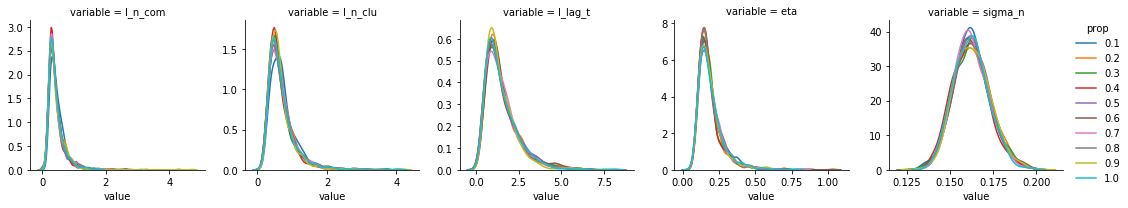

In [145]:
g = sns.FacetGrid(data=results, col='variable', hue='prop', sharex=False, sharey=False)
g.map(sns.distplot, 'value', hist=False).add_legend()

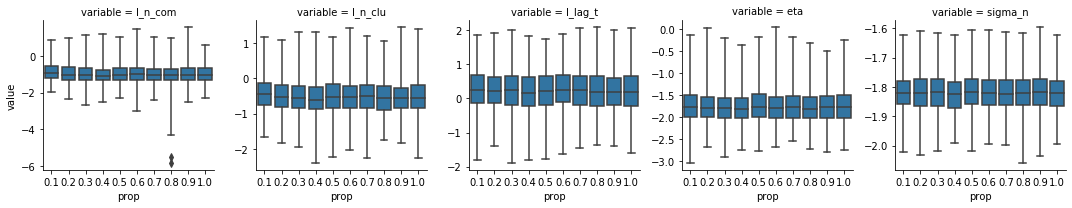

In [155]:
results.loc[:, 'value'] = np.log(results.loc[:, 'value'])

g = sns.FacetGrid(data=results, col='variable',col_wrap=5, sharey=False)
g.map(sns.boxplot,'prop','value', order=results['prop'].unique(), whis=5)